### Unzip and load audio-files

In [11]:
import zipfile
from google.colab import drive

!pip install soundfile
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!rm -rf sample_data

In [0]:
import os
for root, folders, files in os.walk('/content/drive/My Drive/wav-iba/'):
  for file in files:
    if file.endswith('.zip'):
      with zipfile.ZipFile(os.path.join(root, file), 'r') as zip_ref:
        zip_ref.extractall('./sample_data')

In [0]:
!cd sample_data/ && ls 

id10001  id10035  id10069  id10502  id10536  id10570  id10604  id10638	id10672
id10002  id10036  id10070  id10503  id10537  id10571  id10605  id10639	id10673
id10003  id10037  id10071  id10504  id10538  id10572  id10606  id10640	id10674
id10004  id10038  id10072  id10505  id10539  id10573  id10607  id10641	id10675
id10005  id10039  id10073  id10506  id10540  id10574  id10608  id10642	id10676
id10006  id10040  id10074  id10507  id10541  id10575  id10609  id10643	id10677
id10007  id10041  id10075  id10508  id10542  id10576  id10610  id10644	id10678
id10008  id10042  id10076  id10509  id10543  id10577  id10611  id10645	id10679
id10009  id10043  id10077  id10510  id10544  id10578  id10612  id10646	id10680
id10010  id10044  id10078  id10511  id10545  id10579  id10613  id10647	id10681
id10011  id10045  id10079  id10512  id10546  id10580  id10614  id10648	id10682
id10012  id10046  id10080  id10513  id10547  id10581  id10615  id10649	id10683
id10013  id10047  id10081  id10514  id10548  id10582

### A piece of ML =)

In [0]:
import sys
import re
import numpy as np
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import time

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate

from keras import layers
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.utils import plot_model

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K

from sklearn.utils import shuffle

import soundfile as sf
import numpy.random as rand

In [0]:
LIBRISPEECH_SAMPLING_RATE = 16000
SECONDS = 4
downsampling = 4 
FRAGMENT_LENGTH = int(SECONDS * LIBRISPEECH_SAMPLING_RATE)

In [0]:
def make_one_shot_task(N):
    rand_cat = df.sample(1)[['id', 'audio_path']]
    true_cat = rand_cat.iloc[0]
    true_wav = load_wav(true_cat['audio_path'])

    test_cat = df.query(f'(id == {true_cat["id"]}) & (audio_path != "{true_cat["audio_path"]}")')\
                 .sample(1)

    true_test_wav = load_wav(test_cat.iloc[0]['audio_path'])

    true_set = np.array([true_wav for _ in range(N)])
    test_set = np.array([load_wav(row['audio_path']) for index, row in df[df['id'] != true_cat['id']].sample(N).iterrows()])
    test_set[-1] = true_test_wav

    targets = np.zeros((N, ))
    targets[-1] = 1
    return [true_set, test_set], targets

def test_oneshot(model, N, k):
    """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
    n_correct = 0
    for i in range(k):
        inputs, targets = make_one_shot_task(N)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct += 1
    percent_correct = n_correct / k
    return percent_correct

def get_batch(batch_size):
    """Create batch of n pairs, half same class, half different class"""
    rand_cat = df.sample(batch_size)[['id', 'audio_path']]

    pairs = [np.zeros((batch_size, FRAGMENT_LENGTH // downsampling, 1)) for i in range(2)]
    targets = np.zeros((batch_size,))
    targets[batch_size // 2:] = 1

    for i in range(batch_size):
        category = rand_cat.iloc[i]
        pairs[0][i, :] = load_wav(category['audio_path'])

        if i >= batch_size // 2:
            category_2 = df[df['id'] == category['id']].sample(1).iloc[0]
        else:
            category_2 = df[df['id'] != category['id']].sample(1).iloc[0]
          
        pairs[1][i, :] = load_wav(category_2['audio_path'])

    return pairs, targets

def load_wav(path):
    instance, samplerate = sf.read(path)
    return instance[: FRAGMENT_LENGTH:downsampling].reshape(FRAGMENT_LENGTH // downsampling, 1)


def wavs_to_df(path, n=0):
    '''
    params:
        path: str, full path of root wav directory
    return:
        pd: DataFrame, with audio length > SECONDS
    '''
    data = []

    for root, folders, files in os.walk(path):
        for file in files:
            full_path = os.path.join(root, file)
            instance, samplerate = sf.read(full_path)
            data.append([re.search(r'id(\d+)', full_path).group(1), 
                         full_path, 
                         len(instance),
                         len(instance) / LIBRISPEECH_SAMPLING_RATE])

    temp_df = pd.DataFrame(data=data,
                      columns=['id', 'audio_path', 'length', 'seconds'])

    temp_df['id'] = temp_df['id'].astype('int')
    temp_df['seconds'] = temp_df['seconds'].astype('float')
    temp_df['length'] = temp_df['length'].astype('int')

    return temp_df[temp_df['seconds'] > SECONDS]


In [0]:
df = pd.read_csv('/content/drive/My Drive/wav-iba/full.csv')

In [0]:
df = wavs_to_df('sample_data')

In [0]:
def get_baseline_convolutional_encoder(filters, embedding_dimension, input_shape=None, dropout=0.05):
    encoder = Sequential()

    encoder.add(layers.Conv1D(filters, 32, padding='same', activation='relu', input_shape=input_shape))
 
    encoder.add(layers.BatchNormalization())
    encoder.add(layers.SpatialDropout1D(dropout))
    encoder.add(layers.MaxPool1D(4, 4))

    encoder.add(layers.Conv1D(2 * filters, 3, padding='same', activation='relu'))
    encoder.add(layers.BatchNormalization())
    encoder.add(layers.SpatialDropout1D(dropout))
    encoder.add(layers.MaxPool1D())

    encoder.add(layers.Conv1D(3 * filters, 3, padding='same', activation='relu'))
    encoder.add(layers.BatchNormalization())
    encoder.add(layers.SpatialDropout1D(dropout))
    encoder.add(layers.MaxPool1D())

    encoder.add(layers.Conv1D(4 * filters, 3, padding='same', activation='relu'))
    encoder.add(layers.BatchNormalization())
    encoder.add(layers.SpatialDropout1D(dropout))
    encoder.add(layers.MaxPool1D())

    encoder.add(layers.GlobalMaxPool1D())

    encoder.add(layers.Dense(embedding_dimension))

    return encoder


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def build_siamese_net(encoder, input_shape,  distance_metric='uniform_euclidean'):
    input_1 = layers.Input(input_shape)
    input_2 = layers.Input(input_shape)

    encoded_1 = encoder(input_1)
    encoded_2 = encoder(input_2)

   
    distance = Lambda(euclidean_distance,
                      output_shape=eucl_dist_output_shape)
                      ([encoded_1, encoded_2])

    #output = layers.Dense(1, activation='sigmoid')(distance)

    siamese = Model(inputs=[input_1, input_2], outputs=distance)

    return siamese


def test_oneshot(model, N, k):
    """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
    n_correct = 0
    for i in range(k):
        inputs, targets = make_one_shot_task(N)
        probs = model.predict(inputs)
        if np.argmin(probs) == np.argmax(targets):
            n_correct += 1
    percent_correct = n_correct / k
    return percent_correct

In [0]:
def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 1, y_true.dtype)))

def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

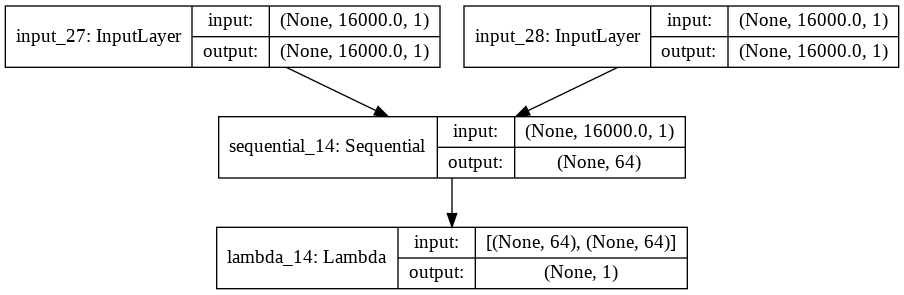

In [0]:
filters = 128
embedding_dimension = 64
dropout = 0.0

input_length = FRAGMENT_LENGTH // downsampling


encoder = get_baseline_convolutional_encoder(filters, embedding_dimension, dropout=dropout)
siamese = build_siamese_net(encoder, (input_length, 1))
opt = RMSprop() #Adam(clipnorm=1.)
siamese.compile(loss=contrastive_loss, optimizer=opt, metrics=[accuracy])
plot_model(siamese, show_shapes=True, to_file='siamese.png')

In [0]:
batch_size = 25
evaluate_every = 50
batch_size = 26
n_iter = 1000 # No. of training iterations
N_way = 10 # how many classes for testing one-shot tasks
n_val = 10 # how many one-shot tasks to validate on
best = -1

In [0]:
losslst, acclst = [], []
full_acclst = []

In [0]:
def save_all(loss, acc, full):
    with open('/content/drive/My Drive/wav-iba/graphics/loss2.pickle', 'wb') as f:
        pickle.dump(loss, f)
    with open('/content/drive/My Drive/wav-iba/graphics/acc2.pickle', 'wb') as f:
        pickle.dump(acc, f)
    with open('/content/drive/My Drive/wav-iba/graphics/full2.pickle', 'wb') as f:
        pickle.dump(full, f)      

In [0]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter + 1):
    (inputs,targets) = get_batch(batch_size)
    loss = siamese.train_on_batch(inputs, targets)
    losslst.append(loss[0])
    acclst.append(loss[1])
      
    if i % evaluate_every == 0: 
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} mins".format(i, (time.time() - t_start) / 60.0))
        print("Train Loss: {0}".format(loss)) 
        val_acc = test_oneshot(siamese, N_way, n_val)
        full_acclst.append(val_acc)

        print(f"Current acc: {val_acc}")
        save_all(losslst, acclst, full_acclst)
        siamese.save_weights(f'/content/drive/My Drive/wav-iba/weights/test-weights.{i}.score{val_acc}.h5')

        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            best = val_acc

Starting training process!
-------------------------------------

 ------------- 

Time for 50 iterations: 0.3867914001146952 mins
Train Loss: [8.049962, 0.5]
Current acc: 0.1
Current best: 0.1, previous best: -1

 ------------- 

Time for 100 iterations: 0.7118527889251709 mins
Train Loss: [0.81157327, 0.53846157]
Current acc: 0.0

 ------------- 

Time for 150 iterations: 0.9911011854807535 mins
Train Loss: [0.38590938, 0.65384614]
Current acc: 0.1
Current best: 0.1, previous best: 0.1

 ------------- 

Time for 200 iterations: 1.2716635942459107 mins
Train Loss: [0.38424858, 0.53846157]
Current acc: 0.1
Current best: 0.1, previous best: 0.1

 ------------- 

Time for 250 iterations: 1.5487627585728962 mins
Train Loss: [0.21327423, 0.5]
Current acc: 0.3
Current best: 0.3, previous best: 0.1

 ------------- 

Time for 300 iterations: 1.8247226397196452 mins
Train Loss: [0.35491455, 0.5769231]
Current acc: 0.3
Current best: 0.3, previous best: 0.3

 ------------- 

Time for 350 iterati

In [0]:
acc, loss = [], []

with open('/content/drive/My Drive/wav-iba/graphics/loss2.pickle', 'rb') as f:
    loss = pickle.load(f)
with open('/content/drive/My Drive/wav-iba/graphics/acc2.pickle', 'rb') as f:
    acc = pickle.load(f)

In [0]:
X = list(range(0, len(acc)))

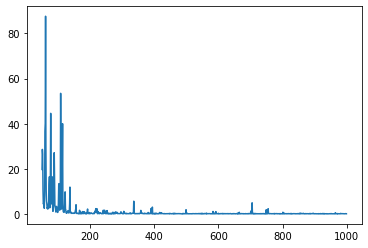

In [0]:
plt.plot(X[50:], loss[50:])

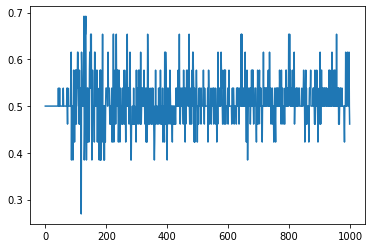

In [0]:
plt.plot(X, acc)

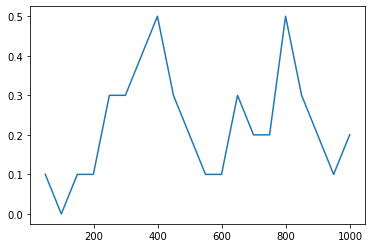

In [14]:
with open('/content/drive/My Drive/wav-iba/graphics/full2.pickle', 'rb') as f:
    full_acc = pickle.load(f)

X2 = list(range(49, 50 * len(full_acc) + 1, 50))
plt.plot(X2, full_acc)